<a href="https://colab.research.google.com/github/jinyingtld/python/blob/main/AI6126_tutorial7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Editing 
In this tutorial, we will get to know:
* basic knowledge regarding image-to-image generation and image style transfer.
* two classic image-to-image translation methods - pix2pix (with paired training data) and CycleGAN (with unpaired training data).
* train pix2pix and CycleGAN
* perform inference with a pretrained models.




## PART I Image-to-Image Translation

### Introduction
Let's first recap some background knowledge about image-to-image translation.
Image-to-image translation usually synthesizes images from another set of images. Image-to-image translation tasks can also be divided into two types: **paired** and **unpaired**. The former usually contains paired image data in the training set therefore is easier for image synthesis; the latter does not need paired training data hence is more challenging.

In this tutorial, we will focus on two methods, pix2pix for paired image-to-image translation and CycleGAN for unpaired image-to-image translation, to learn how to generate high-fidelity images. 

Code reference [Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)

## Requirement 
* Pytorch 
* torchvision
* opencv
* matplotlib
* pillow

Google Collab has install these packages

In [3]:
# Check nvcc version 
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
import os
from PIL import Image 
import matplotlib.pyplot as plt 

import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
from datetime import datetime 
import time
import logging
import random
import cv2
import math 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import Linear, Conv2d, BatchNorm2d, LayerNorm, LeakyReLU, ConvTranspose2d, ReLU, Tanh, InstanceNorm2d
from torch.nn import ReflectionPad2d, ReplicationPad2d

from torch.utils.data import DataLoader
import torchvision.datasets as dset 
import torchvision 
import itertools
from tqdm import tqdm

In [5]:
# Check Pytorch installation 
print(torch.__version__, torch.cuda.is_available())

1.10.0+cu111 True


In [18]:
# Show the current folder
!ls

sample_data


## useful functions

In [6]:
# view images 
def visualize(img_arr, dpi=80):
    plt.figure(figsize=(10,10), dpi=dpi)
    plt.imshow(((img_arr.numpy().transpose(1,2,0) + 1.0)*127.5).astype(np.uint8))
    plt.axis('off')
    plt.show()

# load one image in tensor format 
# transform images into 1*C*H*W; data range [-1,1]
def load_image(filename):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
    img = Image.open(filename)
    img = transform(img)
    return img.unsqueeze(dim=0)

# view images 
def save_image(img, filename):
    tmp = ((img.detach().numpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8)
    cv2.imwrite(filename, cv2.cvtColor(tmp, cv2.COLOR_RGB2BGR))

# custom weights initialization called on networks
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if not(m.bias is None):
            m.bias.data.fill_(0.0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0.0)

# calculate adverserial loss 
class GANLoss(nn.Module):
    def __init__(self, LSGAN=True):
        super(GANLoss, self).__init__()
        #two labels indicating real label and fake label
        self.register_buffer('real_label', torch.tensor(1.0))
        self.register_buffer('fake_label', torch.tensor(0.0))
        if LSGAN:
            # LSGAN loss
            self.loss = nn.MSELoss()
        else:
            # original gan loss 
            self.loss = nn.BCEWithLogitsLoss()
    
    def forward(self, prediction, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        # expand the label to the size of the input feature, i.e., 30*30
        target_tensor = target_tensor.expand_as(prediction)
        return self.loss(prediction, target_tensor)
    

## Dataset Preparation
We need to prepare our datasets before performing inference and training to synthesize images. The preparation for conditional image generation is very easy. You can directly download paired datasets from [here](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/),and **unpaired** datasets from [here](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/). Then, you need to unzip and move corresponding datasets in accordance to the folder structure shown below. 

(You can also just simply run the code below to download and prepare the datasets used in this tutorial)



```
data
├── paired
│    ├── facades
│    ├── maps
│    ├── edges2shoes
│    │    ├── train
│    │    ├── test
├── unpaired
│    ├── facades
│    ├── horse2zebra
│    ├── summer2winter_yosemite
│    │    ├── trainA
│    │    ├── trainB
│    │    ├── testA
│    │    ├── testB
```



As we only need images and the correct folder structure for generation task, further preparation is not necessary. For paired datasets, each samples should be paired iamges that are concatenated in the width dimension. For unpaired datasets, trainA and testA contain images form domain A, whereas train B and test B contain images from domain B. We recommend you to download the existing datasets directly and conduct experiments. Or you can just put your images in the right place.

Here are some code you can directly run to download and prepare the facades(paired) and horse2zebra(unpaired) datasets:

In [19]:
# create the './data/' folder and enter it 
!mkdir -p data/
%cd data/

/content/data


In [12]:
# download the paired dataset 'facades' and unzip it 
!mkdir -p paired/
%cd paired/
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xf facades.tar.gz
!rm -f facades.tar.gz

/content/data/paired
--2022-03-29 03:28:54--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M   928KB/s    in 40s     

2022-03-29 03:29:34 (743 KB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



Here, we have downloaded a small paired dataset facades containing paired images concatenated in the width dimension. Let's look at the directory structure and visualize an example:

In [14]:
# install tree first 
!apt-get -q install tree

# show teh directory structure
!tree facades


Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (50.3 kB/s)
Selecting previously unselected package tree.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
facades
├── test
│   ├── 100.jpg
│   ├── 101.jpg
│   ├── 102.jpg
│   ├── 103.jpg
│   ├── 104.jpg
│   ├── 105.jpg
│   ├── 106.jpg
│   ├── 10.jpg
│   ├── 11.jpg
│   ├── 12.jpg
│   ├── 13.jpg
│   ├── 14.jpg
│   ├── 15.jpg
│   ├── 16.jpg
│   ├── 17.jpg
│   ├── 18.jpg
│   ├── 19.jpg
│   ├── 1.jpg


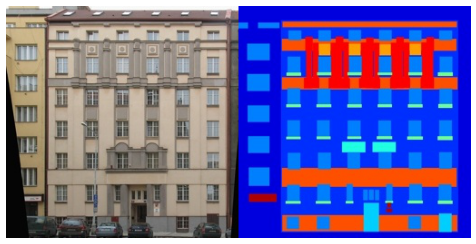

Facades paired image size: (256, 512)


In [15]:
# read the paired image
I = load_image('./facades/test/1.jpg')

visualize(I[0], 60)

# show the paired image size 
print(f'Facades paired image size: {I.size(2), I.size(3)}')

Note that this is a single image compresing a paire of images. On the left is a real-scene image (the groundd truth), and on the right is its corresponding semantic segmentation mask. We usually consider how to generate a photorealistic image from a mask, i.e., right -> left. 

In [24]:
%cd ..
!mkdir unpaired/
%cd unpaired/
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip --no-check-certificate
!unzip -qq horse2zebra.zip
!rm -f horse2zebra.zip

/content/data
/content/data/unpaired
--2022-03-30 07:16:41--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  19.2MB/s    in 7.0s    

2022-03-30 07:16:49 (16.0 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



Here, we have downloaded an unpaired dataset horse2zebra that contains unpaired images (two images, not concatenated). Let's look at the directory structure and visualize an example:

In [25]:
# show the directory structure
!tree horse2zebra

/bin/bash: tree: command not found


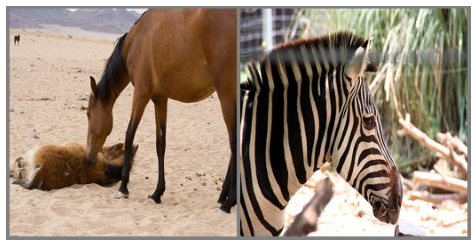

In [26]:
# read the unpaired image
img_horse = load_image('./horse2zebra/testA/n02381460_1110.jpg')
img_zebra = load_image('./horse2zebra/testB/n02391049_860.jpg')

visualize(torchvision.utils.make_grid(torch.cat((img_horse, img_zebra), dim=0), 2, 4), 60)

Note that these are two images that are unpaired (not concatenated).

In [27]:
# change the directory back to the root of MMEditing
%cd ../..
!ls

/content
data  sample_data


## Paired Image-to-Image Translation（pix2pix)

### Network Structure 

The difference between unconditional and conditional image generation is that the latter maps images to images, rather than the latent noise to images. Thus, in conditional image generation, the generator structure also includes an encoder that maps the image to the latent space.

**Pix2pix** first presents the "image-to-image translation" problem, and it uses paired training data. There are two choices for the architecture of the generator:

![pix2pixgenerator](https://drive.google.com/uc?export=view&id=196YecwMvEGlN02lztH7XnQG03izEhMgM)

on the left is a typical "encoder-decoder" generator, and on the right is the "U-Net" generator. The "U-Net" is an encoder-decoder with skip connections between mirrored layers in the encoder and decoder stacks. We mainly implement the "U-Net" generator in pix2pix, because it usually achieves better performance compared with the common "encoder-decoder" generator.


**U-Net** contains an encoder and a decoder.
* Encoder has N=8 downsampling convolutional layers
* Decoder has N=8 upsampling transposed convolutional layers
adding up to 16 layers, where the i-th layer and the (17-i)-th layer are connected

In [23]:
class UnetGenerator(nn.Module):
    def __init__(self, num_downs=8, ngf=64):
        super(UnetGenerator, self).__init__()
        # the innermost two layers, ngf: number generator feature
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, None, innermost=True)
        # the middle six layers, with 512 channels
        for i in range(num_downs - 5)        :
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, unet_block, use_dropout=True)
        # each time add two outer layers, with the channel number halved
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, unet_block)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, unet_block)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, unet_block)
        # the outermost two layers, input 3 channels, output 3 channels
        self.model = UnetSkipConnectionBlock(3, ngf, unet_block, outermost=True)

    def forward(self, input):
        return self.model(input)


**UnetSkipConnectionBlock** defines two skip-connected layers, containing 
**convolutional layer** ---> inner UnetSkipConnectionBlocks--> **Transposed convolutional layer**
* submodule: inner UnetSkipConnectionBlocks--> input_nc + outer_nc
* channels:input_nc --> inner_nc --> outer_nc --> input_nc + outer_nc
* outermost: this block is the outermost layer
* innermost: this block is the innermost layer



In [25]:
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, submodule=None, outermost=False, innermost=False, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(outer_nc)

        if outermost:
            # with all submodule defined, we add the final two layers
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                        kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            # this is the innermost layer, it has no submodule
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                        kernel_size=4, stride=2, padding=1, bias= False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            # middle layers
            # conv/Tconv + BN + LeackReLU/ReLU
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                            kernel_size=4, stride=2, padding=1, bias= False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            
            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else: # skip connection
            return torch.cat([x, self.model(x)], 1)


In [26]:
print(UnetGenerator(num_downs=8, ngf=64))

UnetGenerator(
  (model): UnetSkipConnectionBlock(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): UnetSkipConnectionBlock(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): UnetSkipConnectionBlock(
            (model): Sequential(
              (0): LeakyReLU(negative_slope=0.2, inplace=True)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
              (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): UnetSkipConnectionBlock(
                (model): Sequential(
                  (0): LeakyReLU(negative_slope=0.2, inplace=True)
                  (1): Conv2d(256, 512,

**NLayerDiscriminator** defines PatchGAN

It contains 5 convolutional layers and downsamples a 256*256 images into a 30*30 feature 
meaning it divides the images into 30*30 overlapped patches, and predicts a value for each patch

In [27]:
class NLayerDiscriminator(nn.Module):
    #ndf : number discriminator feature
    def __init__(self, ndf = 64, n_layers=3):
        super(NLayerDiscriminator, self).__init__()
        sequence = [
            nn.Conv2d(6, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2,np.True_)
        ]
        nf_mult = 1
        nf_mult_prev = 1

        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=4, stride=1, padding=1, bias= False),
            nn.BatchNorm2d (ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        # output channel: 1
        # each spatial point: real or fake
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=4, stride=1, padding=1)]  
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

In [28]:
print(NLayerDiscriminator(n_layers=3, ndf=64))

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)


## Train pix2pix

We first create a data loader to load images 
torchvision.datasets.ImageFolder accepts data folder with subfolers, so we first create a new folder for the3 training data

./data/paired/facades/data/train/training_images.jpg

In [29]:
!mkdir ./checkpoint/
!mkdir ./data/paired/facades/data/
c = 'ln -s %s ./data/paired/facades/data/train'%(os.path.join(os.getcwd(), 'data/paired/facades/train/'))
!$c

In [30]:
dataset = dset.ImageFolder(root='./data/paired/facades/data/',
                           transform=transforms.Compose([
                                transforms.Resize(288),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2, drop_last=True)

In [31]:
iterator = iter(dataloader)
data, label = next(iterator)

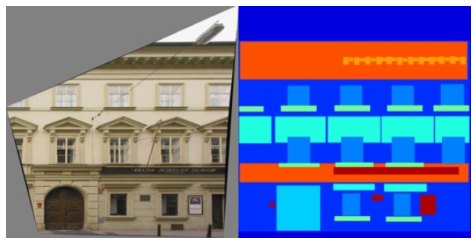

Image size:: torch.Size([1, 3, 288, 576])
Dataset size: 400


In [32]:
visualize(data[0], 60)
print('Image size::', data.shape)
print('Dataset size:', len(dataloader.dataset.imgs))

We define a class that contains G and D, as well as the optimizer and functions to run forward and backward passes.

In [33]:
class Pix2PixModel(nn.Module):
    def __init__(self):
        super(Pix2PixModel, self).__init__()

        self.netG = UnetGenerator(num_downs=8, ngf=64)
        self.netD = NLayerDiscriminator(n_layers=3, ndf=64)

        # for adversarial loss and reconstruction loss
        self.criterionGAN = GANLoss(LSGAN=False)
        self.criterionL1 = torch.nn.L1Loss()
        #optimizers for G and D
        self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(self.netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # G maps A to B
    def forward(self, real_A):
        return self.netG(real_A)
    
    # calculate the gradient of D and update D
    def backward_D(self, real_A, real_B, fake_B):
        # for generated images, D aims to predict it as False
        fake_AB = torch.cat((real_A, fake_B), 1)
        pred_fake = self.netD(fake_AB)
        loss_D_fake = self.criterionGAN(pred_fake, False)
        # for real images, D aims to predict it as True
        real_AB = torch.cat((real_A, real_B), 1)
        pred_real = self.netD(real_AB)
        loss_D_real = self.criterionGAN(pred_real, True)
        loss_D = (loss_D_fake + loss_D_real) * 0.5
        loss_D.backward()
        return loss_D.data.mean().item()

    # calculate the gradient of G and update G
    def backward_G(self, real_A,real_B, fake_B):
        # G tries to confuse D to make it predict the generated image as True
        fake_AB = torch.cat((real_A, fake_B), 1)
        pred_fake = self.netD(fake_AB)
        loss_G_GAN = self.criterionGAN(pred_fake, True)
        # G tries to reconstruct B
        loss_G_L1 = self.criterionL1(fake_B, real_B) * 100
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        return loss_G_GAN.data.mean().item(), loss_G_L1.data.mean().item()

    # training process: train the network to learn to map real_A to real_B
    def optimize_parameters(self, real_A, real_B):
        fake_B = self.forward(real_A)

        self.optimizer_D.zero_grad()
        loss_D = self.backward_D(real_A, real_B, fake_B.detach())
        self.optimizer_D.step()

        self.optimizer_G.zero_grad()
        loss_G_GAN, loss_G_L1 = self.backward_G(real_A, real_B, fake_B)
        self.optimizer_G.step()
        return fake_B, loss_D, loss_G_GAN, loss_G_L1



In [41]:
model = Pix2PixModel()
if torch.cuda.is_available():
    model.cuda()
model.netG.apply(weights_init)
model.netD.apply(weights_init)
print('Model created.')

Model created.


In [ ]:
# batchsize = 1,  #tqdm: progress bar
pbar = tqdm(range(50000), initial=0, smoothing=0.01, dynamic_ncols=True)

model.train()
iterator = iter(dataloader)
for idx in pbar:
    try:
        data, _ = next(iterator)
    except StopIteration:
        iterator = iter(dataloader)
        data, _ = next(iterator)
    
    real_B = data[:,:,:,0:288].cuda()
    real_A = data[:,:,:,288:288*2].cuda()

    w = random.randint(0,288-256)
    h = random.randint(0,288-256)

    real_B = real_B[:,:,w:w+256,h:h+256]
    real_A = real_A[:,:,w:w+256,h:h+256]

    if np.random.rand(1) > 0.5:
        real_A = real_A[:,:,:,torch.arange(real_A.size(3) - 1, -1, -1).long()]
        real_B = real_B[:,:,:,torch.arange(real_B.size(3) - 1, -1, -1).long()]
    
    fake_B, loss_D, loss_G_GAN, loss_G_L1 = model.optimize_parameters(real_A, real_B)

    pbar.set_description(
        (
            f"d: {loss_D:.3f}; g: {loss_G_GAN:.3f}; l1: {loss_G_L1:.3f};"
        )
    )    

    if idx % 1000 == 0:
        visualize(torch.cat((real_A[0], real_B[0], fake_B[0].detach()), dim=2).cpu(), 90)

In [ ]:
torch.save(model.state_dict(),  f"checkpoint/pix2pix-%05d.pt"%(idx))

## Inference of pix2pix

First, let's download the pretrained synthesizer models regarding the facaes(pix2pix) datasets.

In [ ]:
%cd checkpoint/
!gdown --id 1Q5qjD9rYxYoirc_YVadY0QrJArOzkipb
%cd ../

In [ ]:
model.eval()
model.load_state_dict(torch.load('checkpoint/pix2pix-49999.pt'))

In [ ]:
I = load_image('./data/paired/facades/test/10.jpg')
with torch.no_grad():
    real_B = I[:,:,:,0:256]
    real_A = I[:,:,:,256:256*2]   
    output = model(real_A.cuda()).cpu()
visualize(torch.cat((real_A, real_B, output), dim=3)[0], 90)

As mentioned earlier, we hope to generate a real-scene image from its corresponding semantic segmentation mask on the facades dataset. The leftmost image is the input segmentation mask. The image in the middle is our ground truth image. The rightmost image is the fake image generated by our pix2pix pretained model.

## Unpaired Image-to-Image Translation (CycleGAN)

### Network Structure

**CycleGAN** is an important GAN model for unpaired image-to-image translation. For many tasks, paired training data will not be available. Different from pix2pix, CycleGAN requires only unpaired training data.

Our goal is to learn a mapping G: X->Y using an adversarial loss, such that the distribution of images from G(x) is indistinguishable from the distribution Y. Because this mapping is highly under-contrained, CycleGAN couples it with an inverse mapping F:Y->X and introduces a cycle consistency loss to enforce F(G(x))≈ X(and vice versa). 

To achieve this, CycleGAN consists of a pair of generators and discriminators:
![cycleganstructure](https://drive.google.com/uc?export=view&id=1QLp8kfrDx3o7zU0vAg_6fDqD6gt6iM3A)

(a) CycleGAN contains two mapping functions G: X -> Y and F: Y-> X, and two adversarial discriminators $D_Y$ and $D_X$. $D_Y$ encourages G to translate X into outputs indistinguishable from domain Y, while $D_X$ encourages G to translate Y into outpus indistinguishable from domain X. To further regularize the mappings, CycleGAN introduces two cycle consistency losses that capture the intuition that if we translate from one domain to the other and back again, we should arrive at where we started: (b) forward cycle-consistency loss: X-> G(x) ->F(G(x)) ≈ X, and (c) backward cycle-consistency loss: y-> F(y) -> G(F(y)) ≈ y.

CycleGAN model is much more complex thant pix2pix, as the former incorporates more networks and more complicated network structures, as well as having additional constraint(cycle consistency). However, it gains stronger ability in the more challengin task of unpaired image-to-image translation.

**Resblock**

In [7]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()

        conv_block = []
        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0)]
        conv_block += [nn.InstanceNorm2d(dim), nn.ReLU(True)]
        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0)]
        conv_block += [nn.InstanceNorm2d(dim)]

        self.conv_block = nn.Sequential(*conv_block)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        out = x + self.conv_block(x)
        return self.relu(out)

**ResnetGenerator** contains an encoder, a transformer and a decoder
* **encoder**: 3 convolutional layers, downsample twice
* **transformer**: 6 resblocks
* **decoder**: 3 convolutional layers, upsample twice

In [12]:
class ResnetGenerator(nn.Module):
    def __init__(self, ngf=64, n_blocks=6):
        super(ResnetGenerator, self).__init__()
        #encoder
        model = [nn.ReflectionPad2d(3), 
                 nn.Conv2d(3, ngf, kernel_size=7, padding=0),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)] 
        
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i 
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        # Resblocks
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult)] 
        
        # decoder 
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                          kernel_size=3, stride=2,
                                          padding=1, output_padding=1),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, 3, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)
    
    def forward(self, input):
        return self.model(input)


In [13]:
print(ResnetGenerator(ngf=64, n_blocks=9))

ResnetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

**NLayerDiscriminator** defines PatchGAN

the same as pix2pix, except taht using IN not BN


In [14]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, ndf=64, n_layers=3):
        super(NLayerDiscriminator, self).__init__()
        sequence = [
            nn.Conv2d(3, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True)
        ]
        nf_mult = 1
        nf_mult_prev = 1

        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=4, stride=1, padding=1)]
        self.model = nn.Sequential(*sequence)
    
    def forward(self, input):
        return self.model(input)

## Train CycleGAN

we first create two data loaders to load images 
torchvision.datasets.ImageFoler accepts data folder with subfolders, so we first create a new folder for the training data

./data/unpaired/horse2zebra/dataA/train/training_images.jpg
./data/unpaired/horse2zebra/dataB/train/training_images.jpg

In [33]:
!mkdir ./data/unpaired/horse2zebra/dataA/
!mkdir ./data/unpaired/horse2zebra/dataB/
c = 'ln -s %s ./data/unpaired/horse2zebra/dataA/train'%(os.path.join(os.getcwd(), 'data/unpaired/horse2zebra/trainA/'))
!$c
c = 'ln -s %s ./data/unpaired/horse2zebra/dataB/train'%(os.path.join(os.getcwd(), 'data/unpaired/horse2zebra/trainB/'))
!$c

mkdir: cannot create directory ‘./data/unpaired/horse2zebra/dataA/’: File exists


In [34]:
datasetA = dset.ImageFolder(root='./data/unpaired/horse2zebra/dataA/',
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))

dataloaderA = DataLoader(datasetA, batch_size=1, shuffle=True, num_workers=2, drop_last=True)

datasetB = dset.ImageFolder(root='./data/unpaired/horse2zebra/dataB/',
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloaderB = DataLoader(datasetB, batch_size=1, shuffle=True, num_workers=2, drop_last=True)

In [35]:
iteratorA = iter(dataloaderA)
dataA, label= next(iteratorA)
iteratorB = iter(dataloaderB)
dataB, label = next(iteratorB)

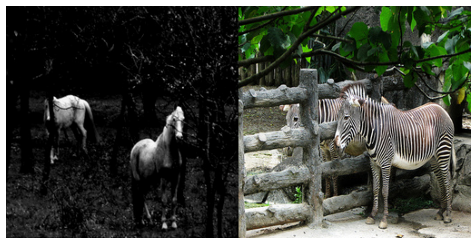

Image size: torch.Size([1, 3, 256, 256])
DatasetA size: 1067 ; DatasetB size: 1334


In [36]:
visualize(torch.cat((dataA[0], dataB[0]), dim=2), 60)
print('Image size:', dataA.shape)
print('DatasetA size:', len(dataloaderA.dataset.imgs), '; DatasetB size:', len(dataloaderB.dataset.imgs))

CycleGAN contains two mapping functions G_A:A->B and G_B: B-> A and two adversarial discriminators D_A and D_B. D_A encourages G_A to translate A into outputs indistinguishable from domain B, while D_B encourages G_A to translate B into outputs indistinguishable from domain A. 

To further regularize the mappings, CycleGAN introduces two cycle consistency losses that capture the intuition that if we translate from one domain to the other band back again, we should arrive at where we started:
* forward cycle-consistency loss A->G_A(A)->G_B(G_A(A)) ≈ A, and 
* backward cycle-consistency loss: B->G_B(B)-> G_A(G_B(B)) ≈ B.
Now, we define a class that contains G_A, G_B and D_A, D_B, as well as the optimizer and functions to run forward and backward passes.

In [39]:
class CycleGANModel(nn.Module):
    def __init__(self):
        super(CycleGANModel, self).__init__()

        self.netG_A = ResnetGenerator(ngf=64, n_blocks=9)
        self.netG_B = ResnetGenerator(ngf=64, n_blocks=9)
        self.netD_A = NLayerDiscriminator(n_layers=3, ndf=64)
        self.netD_B = NLayerDiscriminator(n_layers=3, ndf=64)


        self.criterionGAN = GANLoss()
        self.criterionCycle = torch.nn.L1Loss()
        # itertools.chain make the two parameters update together
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()), lr=0.0002, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_A.parameters(), self.netD_B.parameters()), lr=0.0002, betas=(0.5, 0.999))


    def forward(self, real_A, real_B):
        fake_B = self.netG_A(real_A)   # G_A(A)
        rec_A = self.netG_B(fake_B)    # G_B(G_A(A))
        fake_A = self.netG_B(real_B)   # G_B(B)
        rec_B = self.netG_A(fake_A)    # G_A(G_B(B))
        return [fake_B, rec_A, fake_A, rec_B]

    # calculate the gradient of Ds and update Ds
    def backward_D(self, netD, real, fake):
        # for generated images, D aims to predict it as False
        pred_real = netD(real)
        loss_D_real = self.criterionGAN(pred_real, True)
        # for real images, D aims to predict it as True
        pred_fake = netD(fake.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_D.backward()
        return loss_D.data.mean().item()

    # calculate the gradient of Gs and update Gs
    def backward_G(self, real_A, real_B, fake_B, rec_A, fake_A, rec_B):
        # Gs try to confuse Ds to make them predict the generated image as True
        loss_G_A = self.criterionGAN(self.netD_A(fake_B), True)
        loss_G_B = self.criterionGAN(self.netD_B(fake_A), True)
        # forward cycle-consistency loss || G_B(G_A(A)) - A||
        loss_cycle_A = self.criterionCycle(rec_A, real_A) * 10.0
        # backward cycle-consistency loss || G_A(G_B(B)) - B||
        loss_cycle_B = self.criterionCycle(rec_B, real_B) * 10.0
        loss_G = loss_G_A + loss_G_B + loss_cycle_A + loss_cycle_B
        loss_G.backward()
        return loss_G_A.data.mean().item(), loss_G_B.data.mean().item(), loss_cycle_A.data.mean().item(), loss_cycle_B.data.mean().item()

    # training process
    def optimize_parameters(self, real_A, real_B):
        [fake_B, rec_A, fake_A, rec_B] = self.forward(real_A, real_B)      

        self.optimizer_G.zero_grad()
        loss_G_A, loss_G_B, loss_cycle_A, loss_cycle_B = self.backward_G(real_A, real_B, fake_B, rec_A, fake_A, rec_B)             
        self.optimizer_G.step()
        # 更新D网络
        self.optimizer_D.zero_grad()
        loss_D_A = self.backward_D(self.netD_A, real_B, fake_B.detach()) 
        loss_D_B = self.backward_D(self.netD_B, real_A, fake_A.detach()) 
        self.optimizer_D.step()
        return fake_B, rec_A, fake_A, rec_B, loss_G_A, loss_G_B, loss_cycle_A, loss_cycle_B, loss_D_A, loss_D_B

In [40]:
model = CycleGANModel()
if torch.cuda.is_available():
    model.cuda()
model.netG_A.apply(weights_init)
model.netD_A.apply(weights_init)
model.netG_B.apply(weights_init)
model.netD_B.apply(weights_init)
print('Model created.') 

Model created.


dA: 1.882; dB: 1.940; gA: 1.675; gA: 2.801; ca: 5.598; cb: 5.872;:   0%|          | 0/10000 [00:00<?, ?it/s]

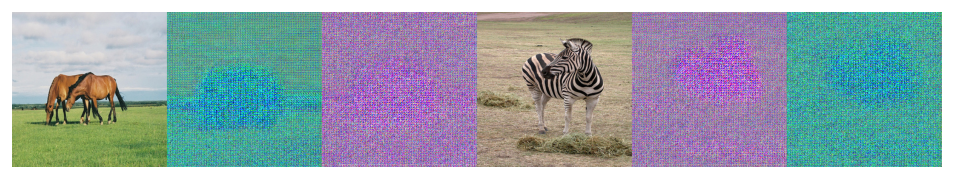

dA: 0.162; dB: 0.345; gA: 0.708; gA: 0.389; ca: 2.390; cb: 2.666;:  20%|██        | 2000/10000 [08:00<31:40,  4.21it/s]

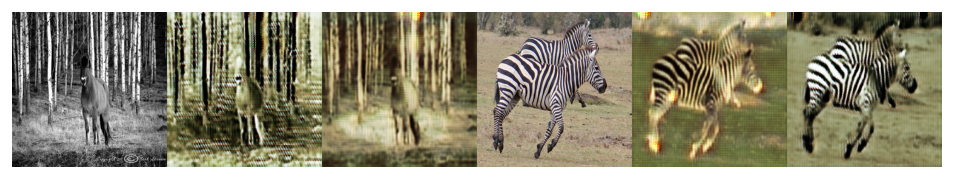

dA: 0.354; dB: 0.148; gA: 0.366; gA: 0.285; ca: 3.250; cb: 2.409;:  40%|████      | 4000/10000 [15:58<23:47,  4.20it/s]

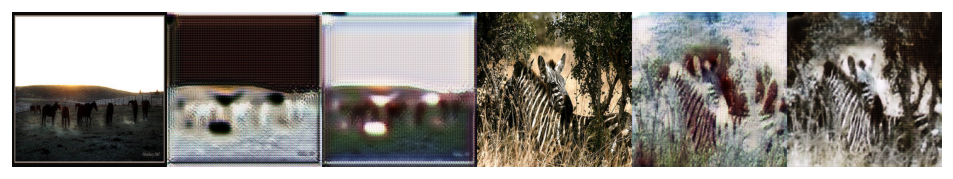

dA: 0.091; dB: 0.299; gA: 0.481; gA: 0.176; ca: 1.527; cb: 2.119;:  60%|██████    | 6000/10000 [24:22<16:24,  4.06it/s]

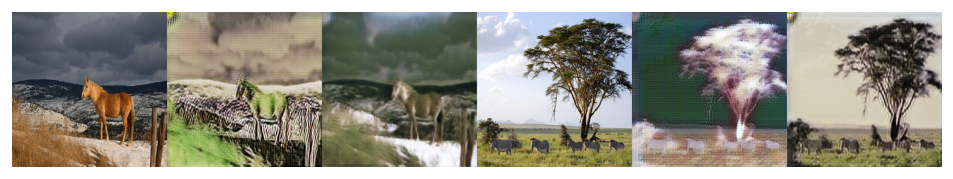

dA: 0.090; dB: 0.167; gA: 0.487; gA: 0.585; ca: 1.900; cb: 3.021;:  80%|████████  | 8000/10000 [32:41<08:49,  3.78it/s]

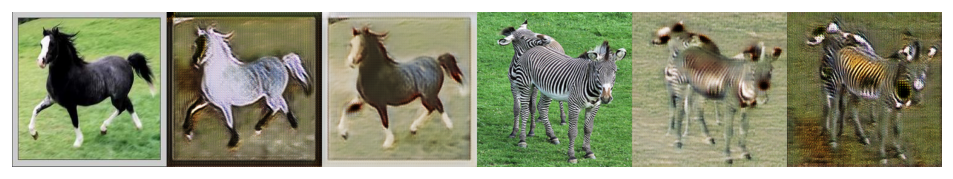

dA: 0.376; dB: 0.327; gA: 0.220; gA: 1.404; ca: 2.412; cb: 1.672;: 100%|██████████| 10000/10000 [41:11<00:00,  4.05it/s]


In [41]:
pbar = tqdm(range(10000), initial=0, smoothing=0.01, dynamic_ncols=True)

iteratorA = iter(dataloaderA)
iteratorB = iter(dataloaderB)
for idx in pbar:
    try:
        data, _ = next(iteratorA)
    except StopIteration:
        iteratorA = iter(dataloaderA)
        data, _ = next(iteratorA
                       ) 
    real_A = data.cuda()
    try:
        data, _ = next(iteratorB)
    except StopIteration:
        iteratorB = iter(dataloaderB)
        data, _ = next(iteratorB) 
    real_B = data.cuda()

    [fake_B, rec_A, fake_A, rec_B, loss_G_A, loss_G_B, loss_cycle_A, 
     loss_cycle_B, loss_D_A, loss_D_B] = model.optimize_parameters(real_A, real_B)
    
    pbar.set_description(
        (
            f"dA: {loss_D_A:.3f}; dB: {loss_D_B:.3f}; gA: {loss_G_A:.3f}; gA: {loss_G_B:.3f}; "
            f"ca: {loss_cycle_A:.3f}; cb: {loss_cycle_B:.3f};"
        )
    )    

    if idx % 2000 == 0:
        visualize(torch.cat((real_A[0], fake_B[0].detach(), rec_A[0].detach(), 
                             real_B[0], fake_A[0].detach(), rec_B[0].detach()), dim=2).cpu(), 120)

In [ ]:
torch.save(model.state_dict(),  f"checkpoint/cyclegan-%05d.pt"%(idx))

## Inference of cyclegan 

First, let's download the pretrained synthesizer models regarding the horse2zebra (CycleGAN) datasets.

In [45]:
# !mkdir ./checkpoint
%cd checkpoint/
!gdown --id  1z-UdYCx_kY8ROuvUNwXOl0_7S8RarWm9
%cd ../

/content/checkpoint
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1z-UdYCx_kY8ROuvUNwXOl0_7S8RarWm9 

/content


/content


In [ ]:
model.eval()
model.load_state_dict(torch.load('checkpoint/cyclegan-99999.pt'))

In [ ]:
As = ['n02381460_490.jpg', 'n02381460_4630.jpg', 'n02381460_4160.jpg', 'n02381460_1870.jpg']
Bs = ['n02391049_4110.jpg', 'n02391049_1950.jpg', 'n02391049_3270.jpg', 'n02391049_3290.jpg']

In [ ]:
model.eval()
for i in range(4):
    I_A = load_image('./data/unpaired/horse2zebra/testA/' + As[i])
    I_B = load_image('./data/unpaired/horse2zebra/testB/' + Bs[i])
    with torch.no_grad():
        fake_B, rec_A, fake_A, rec_B = model(I_A.cuda(), I_B.cuda())
    visualize(torch.cat((I_A[0], fake_B[0].detach().cpu(), rec_A[0].detach().cpu(), 
                         I_B[0], fake_A[0].detach().cpu(), rec_B[0].detach().cpu()), dim=2).cpu(), 120)

## PART II Neural Style Transfer

Let's first recap some background knowledge about neural style transfer.

Neural style transfer transfers the style from a style image S into a content image I.
It is realized by 

* matching the content feature between the output image O and I, 
* matching the style feature (Gram matrix) between O and S,
* O is optimized to minimize the content loss and tye style loss

In this tutorial, we will focus on how to calculate the content feature and the style feature, to learn how to generate style transfer results.

Code reference [Leon A. Gatys](https://github.com/leongatys/PytorchNeuralStyleTransfer)


## Model and Data Preparation 

download pretrain VGG network

In [ ]:
%cd ./checkpoint
!wget -c --no-check-certificate https://bethgelab.org/media/uploads/pytorch_models/vgg_conv.pth
%cd ..

vgg definition that conveniently let's you grab the outputs from any layer

In [ ]:
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [ ]:
#get network
vgg = VGG()
vgg.load_state_dict(torch.load('./checkpoint/vgg_conv.pth'))

for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()
print(vgg)

In [ ]:
# pre and post processing for images
img_size = 512
prep = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),                         
                        ])

postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                             transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                        ])

def postp(tensor): # to clip results in the range [-1, 1]
    t = postpa(tensor) * 2 - 1
    t[t>1] = 1
    t[t<-1] = -1
    return t

In [ ]:
!mkdir ./data/styletransfer/
!wget -O ./data/styletransfer/Tuebingen_Neckarfront.jpg "https://raw.githubusercontent.com/leongatys/PytorchNeuralStyleTransfer/master/Images/Tuebingen_Neckarfront.jpg"
!wget -O ./data/styletransfer/vangogh_starry_night.jpg "https://raw.githubusercontent.com/leongatys/PytorchNeuralStyleTransfer/master/Images/vangogh_starry_night.jpg"
!wget -O ./data/styletransfer/brick.jpg "https://raw.githubusercontent.com/Yijunmaverick/UniversalStyleTransfer/master/input/style/brick.jpg"
!wget -O ./data/styletransfer/seated-nude.jpg "https://raw.githubusercontent.com/Yijunmaverick/UniversalStyleTransfer/master/input/style/seated-nude.jpg"
!wget -O ./data/styletransfer/tiger.jpg "https://raw.githubusercontent.com/Yijunmaverick/UniversalStyleTransfer/master/input/style/088.jpg"

In [ ]:
image_dir = './data/styletransfer/'
filenames = os.listdir(image_dir)
for filename in filenames:
    I = load_image(os.path.join(image_dir, filename))
    visualize(I[0], 30)

Let's recap Gram matrix 

EAch layer of VGG gives C x H X W tensor of feature. 
Each channel is a H x W tensor, which can be transform into a HW dimension vector 
Inner product of two HW-dimensional vectors gives a value of a single element of the Gram matrix 
C vectors itneract with each other, gives Gram Matrix of shape C x C giving unmormalized covariance
By reshaping the features from C x H x W to F = C x HW, it can be simply computed as$G=FF^T$

## Style Transfer 

In [ ]:
# gram matrix and loss 
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2))
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

In [ ]:
print(filenames)

In [ ]:
# load images, ordered as [style_image, content_image]

img_dirs = [image_dir, image_dir]
img_names = ['vangogh_starry_night.jpg', 'Tuebingen_Neckarfront.jpg']
imgs = [Image.open(img_dirs[i] + name) for i, name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch ]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

#opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
opt_img = Variable(content_image.data.clone(), requires_grad=True)

In [ ]:
# define layers, loss functions, weights and compute optimization targets
style_layers = ['r11', 'r21', 'r31', 'r41', 'r51']
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]

# these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

# compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [ ]:
# run style transfer 
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS(opt_img);
n_iter=[0]

out_img = postp(opt_img.data[0].cpu().squeeze())
visualize(out_img, 60)

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data.mean()))
            visualize(out_img, 60)
        return loss

    optimizer.step(closure)


## Texture Synthesis 

In [ ]:
# load images, ordered as [style_image, content_image]

img_dirs = [image_dir, image_dir]
img_names = ['brick.jpg', 'Tuebingen_Neckarfront.jpg']
imgs = [Image.open(img_dirs[i] + name) for i, name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
#opt_img = Variable(content_image.data.clone(), requires_grad=True)


In [ ]:
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [0] # texture synthesis do not requrie content loss
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [ ]:
# run style transfer 
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

out_img = postp(opt_img.data[0].cpu().squeeze())
visualize(out_img, 60)

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data.mean()))
            out_img = postp(opt_img.data[0].cpu().squeeze())
            visualize(out_img, 60)
        return loss
    
    optimizer.step(closure)

## What to Do Next?

We have reached the end of our journey, but there are several places you
could go from here. You could:

-  train for longer to see how good the results get.
-  try different datasets and make possible changes in the
   size of the images and the model architecture.
-  explore more paired image-to-image translation methods, such as [pix2pixHD](https://github.com/NVIDIA/pix2pixHD), [SPADE](https://github.com/NVlabs/SPADE), etc.
-  explore more unpaired image-to-image translation methods, such as [UNIT](https://github.com/mingyuliutw/UNIT), [MUNIT](https://github.com/NVlabs/MUNIT), [StarGAN](https://github.com/yunjey/stargan), etc.
-  explore more image style transfer, such as [AdaIN](https://github.com/xunhuang1995/AdaIN-style), [WCT](https://github.com/sunshineatnoon/PytorchWCT), etc.

We hope these will be of help to you!